In [5]:
# Import Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import matplotlib.pyplot as plt

In [6]:
# Import Datasets

attitudes = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/Attitudes.dta')
employee_characteristics = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/EmployeeCharacteristics.dta')
employee_status = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/EmployeeStatus.dta')
performance = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/Performance.dta')
performance_panel = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/Performance_Panel.dta')
quit_date = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/QuitDate.dta')
quits = pd.read_stata('/content/drive/MyDrive/Sophomore, Semester 2/ECON-318 Project/Datasets/Quits.dta')

In [7]:
# DATA PRE-PROCESSING (Attitudes)

# Attitudes (Only contains a subset of all employees, need to merge tables)
print(attitudes.head())
print(attitudes.info())
print(attitudes.describe())

# This dataset looks reasonable, as there are no missing or non-sensical values that need to be cleaned.
# However, it still needs to be merged with another table because it only contains a subset of all of
# the employees.

   personid  surveyno  post  satisfaction  general  life
0      3906         1   0.0             7       78    18
1      3906         2   1.0             3       72    17
2      3906         3   1.0             5       65    15
3      3906         4   1.0             2       72    19
4      3906         5   1.0             6       73    20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   personid      855 non-null    int32  
 1   surveyno      855 non-null    int8   
 2   post          855 non-null    float32
 3   satisfaction  855 non-null    int8   
 4   general       855 non-null    int8   
 5   life          855 non-null    int8   
dtypes: float32(1), int32(1), int8(4)
memory usage: 10.1 KB
None
           personid    surveyno        post  satisfaction     general  \
count    855.000000  855.000000  855.000000    855.000000  855.000000   

In [ ]:
# DATA PRE-PROCESSING (Employee Characteristics)
print(employee_characteristics.head())
print(employee_characteristics.info())
print(employee_characteristics.describe())

# There are no missing values, but there are non-sensical ones (negative numbers) so we need to clean them.
# Find rows where age is less than or equal to 0.
rows_with_negative_age = employee_characteristics[employee_characteristics['age'] <= 0]
print(rows_with_negative_age)

# Remove two values (personid 31796 and 40320)
employee_characteristics = employee_characteristics[employee_characteristics['age'] >= 0]

In [ ]:
# DATA PRE-PROCESSING (Employee Status)
print(employee_status.head())
print(employee_status.info())
print(employee_status.describe())

# Dataset looks faultless

In [ ]:
# DATA PRE-PROCESSING (Performance)
print(performance.head())
print(performance.info())
print(performance.describe())

# There are no missing values, but there are non-sensical ones (negative numbers) so we need to clean them.
# Find rows where total_monthly_calls is less than or equal to 0.
rows_with_negative_calls = performance[performance['total_monthly_calls'] <= 0]
print(rows_with_negative_calls)

# Remove two values (personid 43534 pre and post)
performance = performance[performance['personid'] != 43534]

In [ ]:
# DATA PRE-PROCESSSING (Performance Panel)
print(performance_panel.head())
print(performance_panel.info())
print(performance_panel.describe())

# Had 139 null values in performance score and 141 in calls per hour columns

# Sort performance score by descending to find outliers
sorted_performance_score_desc = performance_panel.sort_values(by='performance_score', ascending=False)
print(sorted_performance_score_desc.head())

# Calculate mean performance score excluding the value 1000
mean_performance_score = np.mean(performance_panel[performance_panel['performance_score'] != 1000]['performance_score'])

# Replace three values of 1000 with the mean performance score (personid 33128, 33128, 30006)
performance_panel.loc[performance_panel['performance_score'] == 1000, 'performance_score'] = mean_performance_score

# Sort calls per hour by descending to find outliers
calls_per_hour_desc = performance_panel.sort_values(by='calls_per_hour', ascending=False)
print(calls_per_hour_desc.head())

# Replace one value of 200 to 28.800001
performance_panel.loc[performance_panel['calls_per_hour'] == 200, 'calls_per_hour'] = 28.800001

# Replace (139 + 141 = 280) empty values with the mean of the column
performance_panel['performance_score'].fillna(performance_panel['performance_score'].mean(), inplace=True)
performance_panel['calls_per_hour'].fillna(performance_panel['calls_per_hour'].mean(), inplace=True)

# Find rows with negative total monthly calls
negative_monthly_calls = performance_panel[performance_panel['total_monthly_calls'] <= 0]
print(negative_monthly_calls)

# Remove 7 values (all of personid 43534)
performance_panel = performance_panel[performance_panel['personid'] != 43534]

In [ ]:
# DATA PRE-PROCESSING (Quit Date)
print(quit_date.head())
print(quit_date.info())
print(quit_date.describe())

# Dataset looks faultless

In [ ]:
# DATA PRE-PROCESSING (Quit)
print(quits.head())
print(quits.info())
print(quits.describe())

# Dataset looks faultless

In [23]:
# EMPIRICAL STRATEGY (IMPACT OF TREATMENT ON EMPLOYEE SATISFACTION):

# Merge employee_status with attitudes
employee_satisfaction_data = pd.merge(employee_status, attitudes, on="personid")

# Define treatment and control groups
employee_satisfaction_data["treatment_group"] = np.where(employee_satisfaction_data["treatment"] == 1, 1, 0)

# Define time periods
employee_satisfaction_data["post_period"] = np.where(employee_satisfaction_data["post"] == 1, 1, 0)

# Create DiD variable
employee_satisfaction_data["did"] = employee_satisfaction_data["treatment_group"] * employee_satisfaction_data["post_period"]

# Define outcome variable (e.g., satisfaction)
outcome_variable = "satisfaction"

# Construct DiD regression model
X = sm.add_constant(employee_satisfaction_data[["treatment_group", "post_period", "did"]])
y = employee_satisfaction_data[outcome_variable]
did_model = sm.OLS(y, X).fit()

# Print regression results
print(did_model.summary())

                            OLS Regression Results                            
Dep. Variable:           satisfaction   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     11.12
Date:                Thu, 25 Apr 2024   Prob (F-statistic):           3.67e-07
Time:                        04:02:50   Log-Likelihood:                -1454.6
No. Observations:                 855   AIC:                             2917.
Df Residuals:                     851   BIC:                             2936.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.5313      0.166     

The DiD (Differences-in-Differences) coefficient is 0.4974, which suggests that working from home has a positive effect on satisfaction. Additionally, because the p-value is 0.034, the effect is significant at a 95% level.


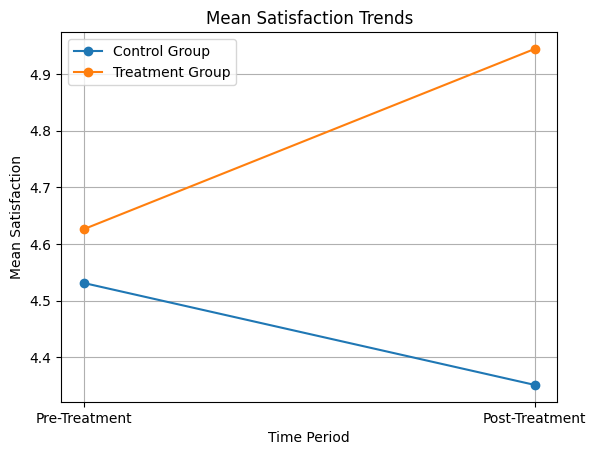

In [15]:
# GRAPH OF MEAN SATISFACTION TRENDS FOR CONTROL VS. TREATMENT (SATISFACTION)

# Determine pre-treatment and post-treatment data
pre_treatment_data = employee_satisfaction_data[employee_satisfaction_data["post_period"] == 0]
post_treatment_data = employee_satisfaction_data[employee_satisfaction_data["post_period"] == 1]

# Calculate mean satisfaction for control group in pre and post-treatment periods
control_pre_treatment_mean = pre_treatment_data[pre_treatment_data["treatment_group"] == 0]["satisfaction"].mean()
control_post_treatment_mean = post_treatment_data[post_treatment_data["treatment_group"] == 0]["satisfaction"].mean()

# Calculate mean satisfaction for treatment group in pre and post-treatment periods
treatment_pre_treatment_mean = pre_treatment_data[pre_treatment_data["treatment_group"] == 1]["satisfaction"].mean()
treatment_post_treatment_mean = post_treatment_data[post_treatment_data["treatment_group"] == 1]["satisfaction"].mean()

# Plot trendlines
plt.plot([0, 1], [control_pre_treatment_mean, control_post_treatment_mean], marker='o', linestyle='-', label="Control Group")
plt.plot([0, 1], [treatment_pre_treatment_mean, treatment_post_treatment_mean], marker='o', linestyle='-', label="Treatment Group")

# Add labels and title
plt.xlabel("Time Period")
plt.ylabel("Mean Satisfaction")
plt.title("Mean Satisfaction Trends")
plt.xticks([0, 1], ["Pre-Treatment", "Post-Treatment"])
plt.legend()
plt.grid(True)
plt.show()

Although the treatment group, on average, had a slightly higher base level of satisfaction compared the the control group, the graph still reinforces the treatment effect. The treatment group satisfaction post-treatment increased significantly whilst the control group satisfaction actually decreased.

In [24]:
# EMPIRICAL STRATEGY (IMPACT OF TREATMENT ON EMPLOYEE RETENTION):

# Merge employee_status with quits and employee_characteristics
employee_retention_data = pd.merge(employee_status, quits, on="personid")
employee_retention_data = pd.merge(employee_retention_data, quit_date, on="personid")
employee_retention_data = pd.merge(employee_retention_data, employee_characteristics, on="personid")

# Define Treatment and Control Groups
treatment_group = employee_retention_data[employee_retention_data["treatment"] == 1]
control_group = employee_retention_data[employee_retention_data["treatment"] == 0]

# Define the Outcome Variable
employee_retention_data['retained'] = (~employee_retention_data['quit'].astype(bool)).astype(int)

# Define Control Variables
control_vars = ['age', 'married', 'high_school', 'tenure', 'grosswage', 'bonus', 'basewage']

# Estimate the Logistic Regression Model
X = employee_retention_data[['treatment'] + control_vars]
X = sm.add_constant(X)
y = employee_retention_data['retained']
model = sm.Logit(y, X)
result = model.fit()

# Print regression results
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.121025
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               retained   No. Observations:                 2223
Model:                          Logit   Df Residuals:                     2214
Method:                           MLE   Df Model:                            8
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                 0.04952
Time:                        04:12:26   Log-Likelihood:                -269.04
converged:                       True   LL-Null:                       -283.05
Covariance Type:            nonrobust   LLR p-value:                 0.0004680
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.7519      1.939      1.419      0.156      -1.049       6.553
treatment       0.7726    

The treatment coefficient is 0.7726, which suggests that those working from home were approximately 0.7726 times more likely to stay compared to the control group. Additionally, the p-value of treatment is 0.005, which suggests that the variable is significant at a 99% level.

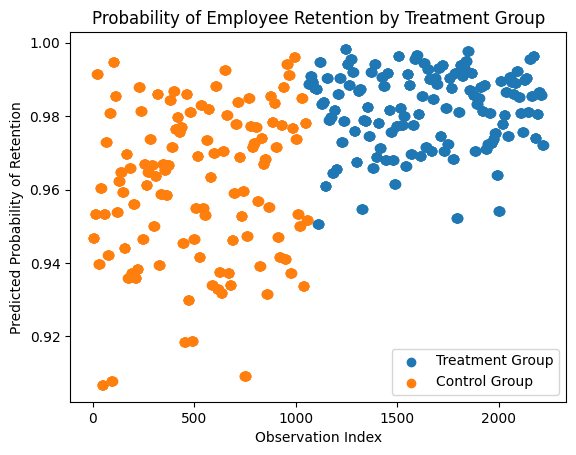

In [17]:
# PROBABILITY PLOT (RETENTION)

# Predict probabilities of retention for treatment and control groups
treatment_probs = result.predict(X.loc[X['treatment'] == 1])
control_probs = result.predict(X.loc[X['treatment'] == 0])

# Create a scatter plot for treatment group
plt.scatter(treatment_probs.index, treatment_probs, label='Treatment Group', marker='o')

# Create a scatter plot for control group
plt.scatter(control_probs.index, control_probs, label='Control Group', marker='o')

# Add labels and title
plt.xlabel('Observation Index')
plt.ylabel('Predicted Probability of Retention')
plt.title('Probability of Employee Retention by Treatment Group')

# Add legend
plt.legend()

# Show plot
plt.show()

As shown by the probability plot, the variance in the treatment group data is much less than the control group with regard to retention probability. Additionally, the mean probability of retention of the treatment group is much higher than the control group, which reinforces the claim that working from home improves employee retention.

In [19]:
# EMPIRICAL STRATEGY (IMPACT OF TREATMENT ON PERFORMANCE)

# Merge Data
employee_performance_data = pd.merge(employee_status, performance_panel, on='personid')
employee_performance_data = pd.merge(employee_performance_data, attitudes, on='personid')
employee_performance_data = pd.merge(employee_performance_data, employee_characteristics, on='personid')

# Define Treatment and Control Groups
treatment_group = employee_performance_data[employee_performance_data['treatment'] == 1]
control_group = employee_performance_data[employee_performance_data['treatment'] == 0]

# Define the Outcome Variable
outcome_variable = 'calls_per_hour'

# Define the Interaction Variable
employee_performance_data['did'] = employee_performance_data['treatment'] * employee_performance_data['post_x']

# Define Control Variables
control_vars = ['age', 'married', 'high_school', 'tenure', 'grosswage', 'bonus', 'basewage', 'satisfaction', 'general', 'life']

# Estimate the DiD Model
X = employee_performance_data[['treatment', 'post_x', 'did'] + control_vars]
X = sm.add_constant(X)
y = employee_performance_data[outcome_variable]

model = sm.OLS(y, X).fit()

# Interpret Results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         calls_per_hour   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     74.31
Date:                Thu, 25 Apr 2024   Prob (F-statistic):          2.31e-192
Time:                        02:01:02   Log-Likelihood:                -38026.
No. Observations:               16335   AIC:                         7.608e+04
Df Residuals:                   16321   BIC:                         7.619e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           17.6838      0.316     56.013   

The DiD (difference-in-differences) coefficient is 0.5643, which suggests that the treatment has a positive impact on performance. Additionally, the p-value of DiD is much less than 0.001, which suggests that the variable is significant at a 99% level.